In [ ]:
# Import necessary libraries
import pandas as pd
import nltk
import json

# Download ALL necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab') # <-- This is the new line we added
nltk.download('stopwords')
nltk.download('vader_lexicon')

# --- ROBUST DATA LOADING ---
data = []
with open('News_Category_Dataset_v3.json', 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            pass

df = pd.DataFrame(data)

print("Successfully loaded the data! Here are the first 5 rows:")
print(df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Successfully loaded the data! Here are the first 5 rows:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when h

In [ ]:
# Initialize the stemmer and get the set of English stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Tokenize the text (split into words) and convert to lowercase
    tokens = nltk.word_tokenize(text.lower())

    # 2. Remove stopwords and stem the remaining words
    # We also keep only alphabetic words to remove punctuation and numbers
    filtered_tokens = [stemmer.stem(w) for w in tokens if w.isalpha() and w not in stop_words]

    # 3. Join the tokens back into a single string
    return " ".join(filtered_tokens)

# Apply the function to your 'headline' column to create a new 'processed_headline' column
# This is the most intensive step and might take a minute or two to run on all 200,000+ headlines.
print("Starting text preprocessing... (This may take a moment)")
df['processed_headline'] = df['headline'].apply(preprocess_text)
print("Text preprocessing complete.")

# Display the original vs. the new processed headline for the first 5 rows to see the difference
print("\nHere's a comparison of the original vs. processed headlines:")
print(df[['headline', 'processed_headline']].head())

Starting text preprocessing... (This may take a moment)
Text preprocessing complete.

Here's a comparison of the original vs. processed headlines:
                                            headline  \
0  Over 4 Million Americans Roll Up Sleeves For O...   
1  American Airlines Flyer Charged, Banned For Li...   
2  23 Of The Funniest Tweets About Cats And Dogs ...   
3  The Funniest Tweets From Parents This Week (Se...   
4  Woman Who Called Cops On Black Bird-Watcher Lo...   

                                  processed_headline  
0          million american roll sleev covid booster  
1  american airlin flyer charg ban life punch fli...  
2                        funniest tweet cat dog week  
3                         funniest tweet parent week  
4                  woman call cop black lose lawsuit  


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

# Function to get the sentiment category from the compound score
def get_sentiment(text):
    # Get the polarity scores dictionary
    scores = sid.polarity_scores(text)
    # Decide sentiment based on the compound score
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the original 'headline' column for the most accurate sentiment
print("Starting sentiment analysis...")
df['sentiment'] = df['headline'].apply(get_sentiment)
print("Sentiment analysis complete.")

# Display the first 5 rows with the new 'sentiment' column
print("\nHere are the headlines with their calculated sentiment:")
print(df[['headline', 'sentiment']].head())

Starting sentiment analysis...
Sentiment analysis complete.

Here are the headlines with their calculated sentiment:
                                            headline sentiment
0  Over 4 Million Americans Roll Up Sleeves For O...   Neutral
1  American Airlines Flyer Charged, Banned For Li...  Negative
2  23 Of The Funniest Tweets About Cats And Dogs ...  Positive
3  The Funniest Tweets From Parents This Week (Se...  Positive
4  Woman Who Called Cops On Black Bird-Watcher Lo...  Negative


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# --- Topic Modeling ---

# 1. Vectorize the text. This converts our text into a matrix of word counts.
# max_df=0.9 means "ignore words that appear in more than 90% of documents" (too common)
# min_df=2 means "ignore words that appear in less than 2 documents" (too rare)
print("Vectorizing text for topic modeling...")
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['processed_headline'].dropna()) # dropna() handles any empty headlines

# 2. Apply the LDA model. We are asking it to find 10 topics.
print("Applying Latent Dirichlet Allocation (LDA) model...")
LDA = LatentDirichletAllocation(n_components=10, random_state=42)
LDA.fit(doc_term_matrix)

# 3. Display the topics and their top words.
print("\nTopic modeling complete. Here are the top 10 words for each topic:")
for i, topic in enumerate(LDA.components_):
    # Get the top 10 words for the current topic
    top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"\n--- Topic #{i} ---")
    print(top_words)

Vectorizing text for topic modeling...
Applying Latent Dirichlet Allocation (LDA) model...

Topic modeling complete. Here are the top 10 words for each topic:

--- Topic #0 ---
['need', 'senat', 'know', 'congress', 'email', 'democrat', 'presid', 'deal', 'obama', 'say']

--- Topic #1 ---
['jimmi', 'york', 'democrat', 'berni', 'new', 'sander', 'win', 'live', 'hillari', 'clinton']

--- Topic #2 ---
['ted', 'peopl', 'fight', 'cruz', 'kid', 'assault', 'sexual', 'new', 'right', 'women']

--- Topic #3 ---
['like', 'girl', 'work', 'new', 'news', 'best', 'make', 'care', 'health', 'way']

--- Topic #4 ---
['like', 'woman', 'cop', 'say', 'suprem', 'day', 'kill', 'court', 'polic', 'man']

--- Topic #5 ---
['death', 'muslim', 'jenner', 'women', 'say', 'refuge', 'kill', 'elect', 'week', 'attack']

--- Topic #6 ---
['need', 'princ', 'control', 'mark', 'violenc', 'celebr', 'shoot', 'video', 'new', 'gun']

--- Topic #7 ---
['colleg', 'judg', 'plan', 'say', 'law', 'state', 'north', 'student', 'america',

Generating Sentiment Pie Chart...


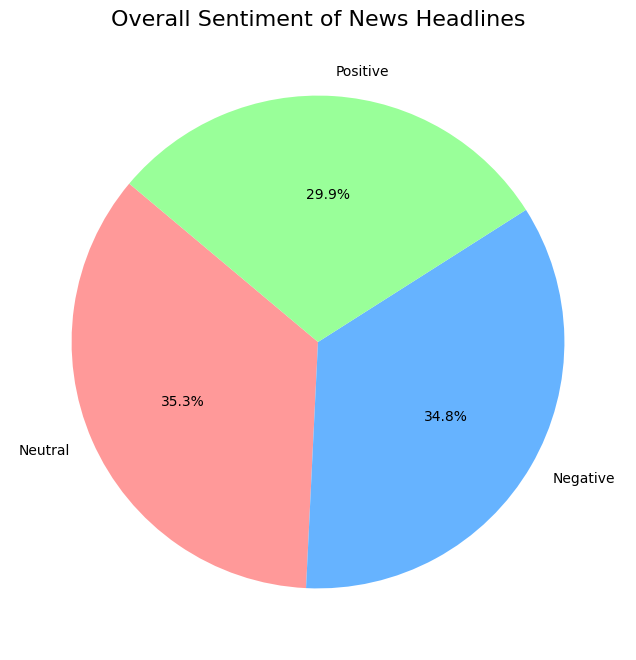


Generating Word Cloud...


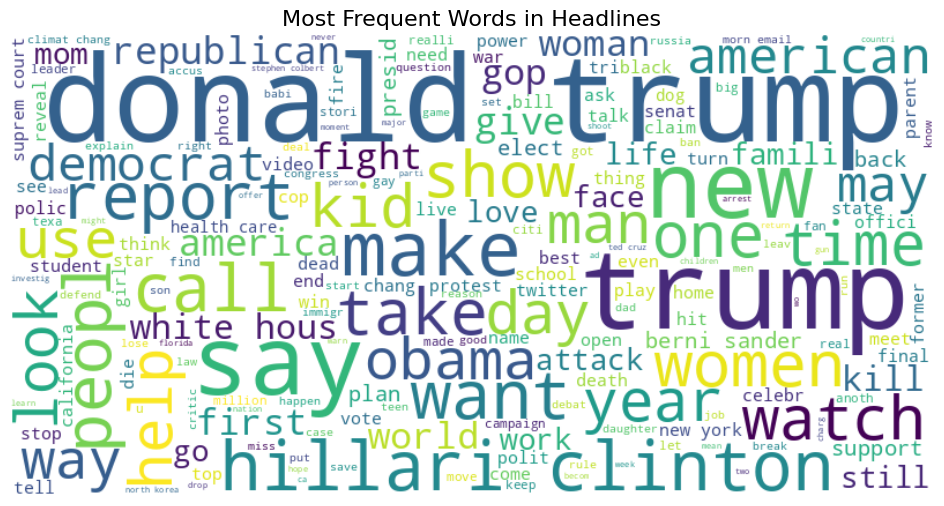

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# --- Visualization 1: Sentiment Pie Chart ---
print("Generating Sentiment Pie Chart...")
plt.figure(figsize=(8, 8))
# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()
# Create the pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Overall Sentiment of News Headlines', fontsize=16)
plt.ylabel('') # Hides the 'sentiment' label on the side
plt.show()


# --- Visualization 2: Word Cloud ---
print("\nGenerating Word Cloud...")
# Join all the processed headlines into one big string of text
all_words = ' '.join([text for text in df['processed_headline'].dropna()])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_words)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Hide the axes
plt.title('Most Frequent Words in Headlines', fontsize=16)
plt.show()

In [ ]:
import numpy as np

# --- Time-Series Preparation ---

# 1. Convert the 'date' column to a proper datetime format
print("Converting 'date' column to datetime objects...")
df['date'] = pd.to_datetime(df['date'])

# 2. Get the dominant topic for each headline
# The .transform() method tells us the probability of each topic for each document.
# We use np.argmax() to find which topic has the highest probability.
print("Assigning a dominant topic to each headline...")
topic_results = LDA.transform(doc_term_matrix)
df['topic'] = topic_results.argmax(axis=1)

print("Time-series preparation complete.")

# Display the first 5 rows with the new 'topic' column and formatted 'date'
print("\nHere is the data with the new 'topic' column:")
print(df[['date', 'headline', 'topic']].head())

Converting 'date' column to datetime objects...
Assigning a dominant topic to each headline...
Time-series preparation complete.

Here is the data with the new 'topic' column:
        date                                           headline  topic
0 2022-09-23  Over 4 Million Americans Roll Up Sleeves For O...      7
1 2022-09-23  American Airlines Flyer Charged, Banned For Li...      0
2 2022-09-23  23 Of The Funniest Tweets About Cats And Dogs ...      5
3 2022-09-23  The Funniest Tweets From Parents This Week (Se...      5
4 2022-09-22  Woman Who Called Cops On Black Bird-Watcher Lo...      4


Grouping data by year and topic...
Generating the time-series plot...


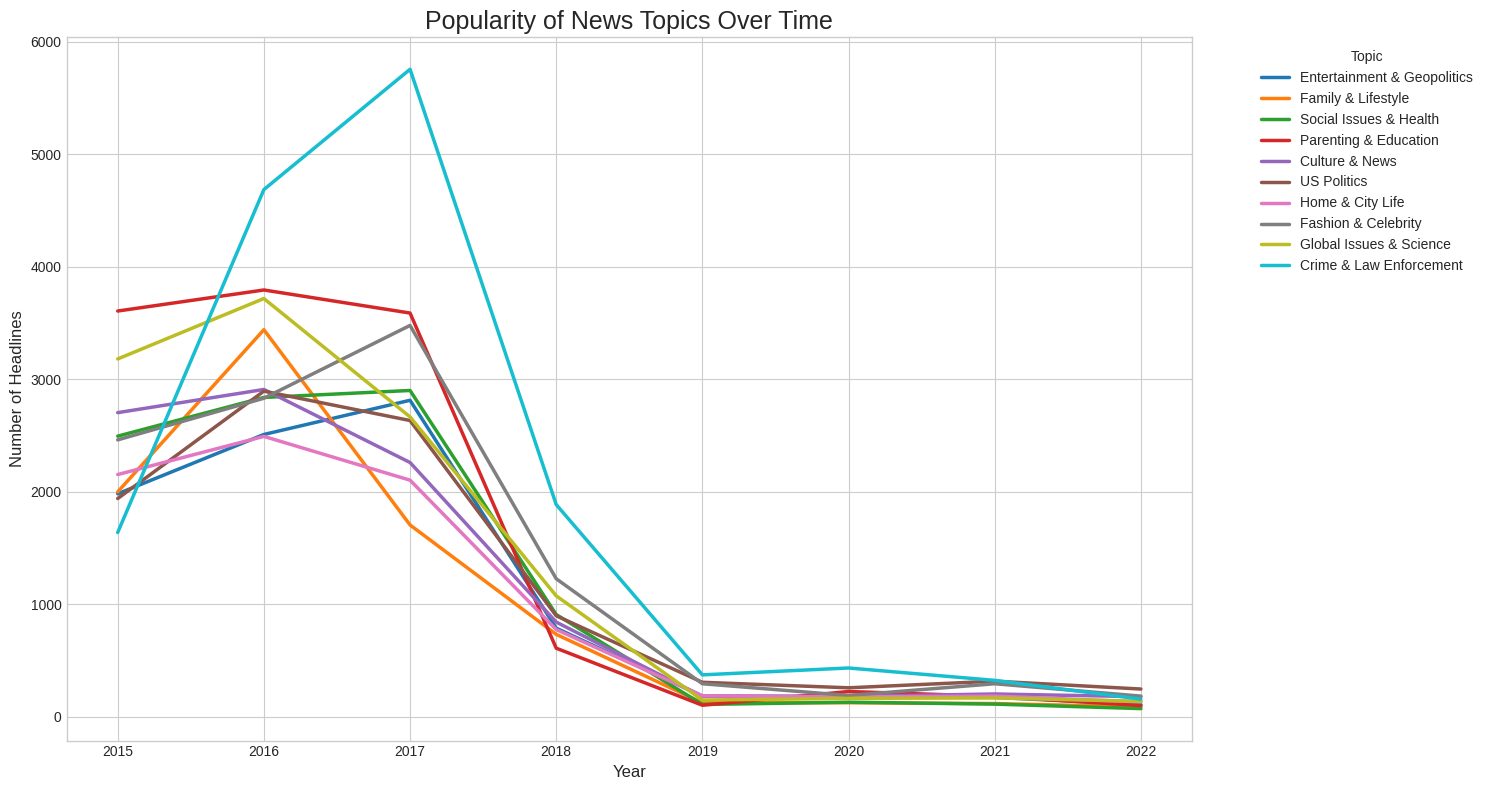

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Time-Series Visualization ---

print("Grouping data by year and topic...")
# We create a new column 'year' from the 'date' column
df['year'] = df['date'].dt.year

# Group by year and topic, then count the number of headlines in each group
yearly_topic_counts = df.groupby(['year', 'topic']).size().reset_index(name='headline_count')

# Create a mapping from topic number to the names we identified
topic_names = {
    0: "Entertainment & Geopolitics",
    1: "Family & Lifestyle",
    2: "Social Issues & Health",
    3: "Parenting & Education",
    4: "Culture & News",
    5: "US Politics",
    6: "Home & City Life",
    7: "Fashion & Celebrity",
    8: "Global Issues & Science",
    9: "Crime & Law Enforcement"
}

# Replace the topic numbers with our names for a better legend
yearly_topic_counts['topic_name'] = yearly_topic_counts['topic'].map(topic_names)


# --- Create the Plot ---
print("Generating the time-series plot...")
plt.style.use('seaborn-v0_8-whitegrid') # Sets a nice style for the plot
plt.figure(figsize=(15, 8)) # Make the plot larger

# Use seaborn to create a line plot. It will automatically create different colored lines for each topic.
sns.lineplot(data=yearly_topic_counts,
             x='year',
             y='headline_count',
             hue='topic_name', # This tells seaborn to draw a separate line for each topic name
             palette='tab10', # A color scheme
             linewidth=2.5)

plt.title('Popularity of News Topics Over Time', fontsize=18)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Headlines', fontsize=12)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside the plot
plt.tight_layout() # Adjust layout to make sure everything fits
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# --- Predictive Modeling Preparation ---

# 1. Define our features (X) and target (y)
# We use the cleaned 'processed_headline' as our input feature.
# We want to predict the 'category' of the news.
X = df['processed_headline'].dropna()
y = df.loc[X.index, 'category'] # Ensure y matches the filtered X

# 2. Split the data into training and testing sets
# We'll use 80% of the data to train the model and 20% to test it.
# random_state=42 ensures that we get the same split every time we run the code.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data preparation for modeling complete.")
print(f"Training set size: {len(X_train)} headlines")
print(f"Testing set size: {len(X_test)} headlines")

Data preparation for modeling complete.
Training set size: 82712 headlines
Testing set size: 20678 headlines


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Text Vectorization ---

# 1. Initialize the TF-IDF Vectorizer
# We'll limit it to the top 5000 most frequent words to keep it manageable.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# 2. Fit and transform the training data
# .fit_transform() learns the vocabulary from the training data and converts it to a matrix.
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# 3. Only transform the testing data
# .transform() uses the vocabulary already learned from the training data to convert the test set.
# This prevents the model from getting information about the test set during training.
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Text vectorization complete.")
print(f"Shape of the training data matrix: {X_train_tfidf.shape}")
print(f"Shape of the testing data matrix: {X_test_tfidf.shape}")

Text vectorization complete.
Shape of the training data matrix: (82712, 5000)
Shape of the testing data matrix: (20678, 5000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# --- Model Training and Evaluation ---

# 1. Initialize and train the Logistic Regression model
print("Training the Logistic Regression model...")
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_tfidf, y_train)
print("Model training complete.")

# 2. Make predictions on the test set
print("\nMaking predictions on the test set...")
y_pred = logreg_model.predict(X_test_tfidf)

# 3. Evaluate the model's performance
print("Evaluating model performance...")
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {accuracy:.2%}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training the Logistic Regression model...
Model training complete.

Making predictions on the test set...
Evaluating model performance...

Overall Accuracy: 59.05%

Classification Report:
                precision    recall  f1-score   support

          ARTS       0.40      0.02      0.04        84
ARTS & CULTURE       0.41      0.24      0.30       268
  BLACK VOICES       0.53      0.33      0.41       668
      BUSINESS       0.49      0.36      0.41       504
       COLLEGE       0.59      0.30      0.40       122
        COMEDY       0.67      0.42      0.51       684
         CRIME       0.55      0.46      0.50       478
CULTURE & ARTS       0.00      0.00      0.00         9
     EDUCATION       0.44      0.18      0.26       116
 ENTERTAINMENT       0.56      0.76      0.64      2579
   ENVIRONMENT       0.00      0.00      0.00        24
         FIFTY       0.38      0.05      0.09       103
  FOOD & DRINK       0.00      0.00      0.00        23
     GOOD NEWS       0.45  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# --- Handling Class Imbalance by Grouping Categories ---

print("Original category counts (Top 10):")
print(df['category'].value_counts().head(10))

# 1. Define the mapping from old categories to new, broader categories
category_mapping = {
    'ARTS & CULTURE': 'CULTURE & ARTS',
    'ARTS': 'CULTURE & ARTS',
    'CULTURE & ARTS': 'CULTURE & ARTS',
    'STYLE & BEAUTY': 'STYLE & FASHION',
    'STYLE': 'STYLE & FASHION',
    'PARENTING': 'PARENTS & FAMILY',
    'PARENTS': 'PARENTS & FAMILY',
    'HOME & LIVING': 'HOME & LIVING',
    'FOOD & DRINK': 'FOOD & DRINK',
    'TASTE': 'FOOD & DRINK',
    'TRAVEL': 'TRAVEL',
    'WELLNESS': 'HEALTHY LIVING',
    'THE WORLDPOST': 'WORLD NEWS',
    'WORLDPOST': 'WORLD NEWS'
}

# 2. Create a new column with the grouped categories
# .replace() will apply our mapping. Categories not in the mapping will remain unchanged.
df['category_grouped'] = df['category'].replace(category_mapping)

# 3. For very rare categories, let's group them into an 'OTHER' category
# First, get the counts of the newly grouped categories
value_counts = df['category_grouped'].value_counts()
# Identify categories with fewer than 100 samples
to_other = value_counts[value_counts < 100].index
# Replace them with 'OTHER'
df.loc[df['category_grouped'].isin(to_other), 'category_grouped'] = 'OTHER'


print("\nNew, grouped category counts (Top 10):")
print(df['category_grouped'].value_counts().head(10))

Original category counts (Top 10):
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
Name: count, dtype: int64

New, grouped category counts (Top 10):
category_grouped
POLITICS            35602
HEALTHY LIVING      24639
ENTERTAINMENT       17362
PARENTS & FAMILY    12746
STYLE & FASHION     12068
TRAVEL               9900
WORLD NEWS           9542
FOOD & DRINK         8436
QUEER VOICES         6347
BUSINESS             5992
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# --- Re-run the entire modeling pipeline with the grouped categories ---

# 1. Define features (X) and our NEW target (y)
X = df['processed_headline'].dropna()
y = df.loc[X.index, 'category_grouped'] # Use the new grouped column

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Vectorize the text
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 4. Train the new model
print("Training the new model on grouped categories...")
new_logreg_model = LogisticRegression(max_iter=1000, random_state=42)
new_logreg_model.fit(X_train_tfidf, y_train)
print("Model training complete.")

# 5. Evaluate the new model
print("\nMaking predictions with the new model...")
y_pred_new = new_logreg_model.predict(X_test_tfidf)
accuracy_new = accuracy_score(y_test, y_pred_new)

print(f"\nNew Overall Accuracy: {accuracy_new:.2%}")
print("\nNew Classification Report:")
print(classification_report(y_test, y_pred_new))

Training the new model on grouped categories...
Model training complete.

Making predictions with the new model...

New Overall Accuracy: 60.78%

New Classification Report:
                  precision    recall  f1-score   support

    BLACK VOICES       0.54      0.32      0.40       668
        BUSINESS       0.47      0.32      0.38       504
         COLLEGE       0.54      0.30      0.38       122
          COMEDY       0.65      0.37      0.47       685
           CRIME       0.51      0.44      0.47       478
  CULTURE & ARTS       0.50      0.29      0.37       360
       EDUCATION       0.49      0.22      0.31       116
   ENTERTAINMENT       0.57      0.76      0.65      2579
     ENVIRONMENT       0.00      0.00      0.00        24
           FIFTY       0.43      0.06      0.10       103
    FOOD & DRINK       0.65      0.55      0.60       303
       GOOD NEWS       0.38      0.15      0.21       202
           GREEN       0.42      0.27      0.33       317
  HEALTHY LIVI

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Import necessary libraries
import pandas as pd
import nltk
import json

# Download ALL necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng') # <-- Add this new line

# --- ROBUST DATA LOADING ---
data = []
with open('News_Category_Dataset_v3.json', 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            pass

df = pd.DataFrame(data)

print("Successfully loaded the data! Here are the first 5 rows:")
print(df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk

Successfully loaded the data! Here are the first 5 rows:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when h

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet # To get parts of speech for words

# --- Advanced NLP: Lemmatization ---

# 1. Download the necessary NLTK data for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger') # Needed for Part-of-Speech tagging

# 2. Initialize the Lemmatizer
lemmatizer = WordNetLemmatizer()

# 3. Helper function to get the correct Part-of-Speech tag
# Lemmatization works best if it knows whether a word is a noun, verb, adjective, etc.
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # Default to noun if not found

# 4. Create the new lemmatization function
def lemmatize_text(text):
    # Tokenize, lowercase, and remove stopwords
    tokens = [w for w in nltk.word_tokenize(text.lower()) if w.isalpha() and w not in stop_words]
    # Lemmatize each word with its correct POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    return " ".join(lemmatized_tokens)

# Apply the new, more intelligent function to the 'headline' column
print("Starting text processing with Lemmatization... (This will take a few minutes)")
df['lemmatized_headline'] = df['headline'].apply(lemmatize_text)
print("Lemmatization complete.")

# Compare the old stemming with our new lemmatization
print("\nComparison of Stemming vs. Lemmatization:")
print(df[['headline', 'lemmatized_headline']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Starting text processing with Lemmatization... (This will take a few minutes)
Lemmatization complete.

Comparison of Stemming vs. Lemmatization:
                                            headline  \
0  Over 4 Million Americans Roll Up Sleeves For O...   
1  American Airlines Flyer Charged, Banned For Li...   
2  23 Of The Funniest Tweets About Cats And Dogs ...   
3  The Funniest Tweets From Parents This Week (Se...   
4  Woman Who Called Cops On Black Bird-Watcher Lo...   

                                 lemmatized_headline  
0         million american roll sleeve covid booster  
1  american airline flyer charge ban life punch f...  
2                        funniest tweet cat dog week  
3                         funniest tweet parent week  
4                 woman call cop black loses lawsuit  


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# --- Re-run the modeling pipeline with LEMMATIZED data ---

# 1. Define features (X) using the new lemmatized column and our grouped target (y)
X = df['lemmatized_headline'].dropna()
y = df.loc[X.index, 'category_grouped']

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Vectorize the text
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 4. Train the final model
print("Training the final model on lemmatized categories...")
final_model = LogisticRegression(max_iter=1000, random_state=42)
final_model.fit(X_train_tfidf, y_train)
print("Model training complete.")

# 5. Evaluate the final model
print("\nMaking predictions with the final model...")
y_pred_final = final_model.predict(X_test_tfidf)
accuracy_final = accuracy_score(y_test, y_pred_final)

print(f"\n--- FINAL RESULTS ---")
print(f"Accuracy with Stemming: 60.78%")
print(f"Accuracy with Lemmatization: {accuracy_final:.2%}")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final))

Training the final model on lemmatized categories...
Model training complete.

Making predictions with the final model...

--- FINAL RESULTS ---
Accuracy with Stemming: 60.78%
Accuracy with Lemmatization: 61.48%

Final Classification Report:
                  precision    recall  f1-score   support

    BLACK VOICES       0.52      0.31      0.39       917
        BUSINESS       0.50      0.40      0.44      1198
         COLLEGE       0.51      0.31      0.39       229
          COMEDY       0.56      0.38      0.45      1080
           CRIME       0.55      0.49      0.52       712
  CULTURE & ARTS       0.55      0.36      0.44       784
         DIVORCE       0.79      0.58      0.67       685
       EDUCATION       0.38      0.20      0.26       203
   ENTERTAINMENT       0.57      0.68      0.62      3473
     ENVIRONMENT       0.50      0.20      0.28       289
           FIFTY       0.50      0.08      0.14       280
    FOOD & DRINK       0.71      0.72      0.72      1687
   

In [ ]:
import pickle

# --- Save Final Data and Model for the App ---

# 1. Save the processed DataFrame to a compressed file (Parquet is efficient)
print("Saving processed DataFrame...")
df.to_parquet('processed_headlines.parquet')

# 2. Save the final trained model and the vectorizer using pickle
print("Saving the TF-IDF vectorizer...")
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("Saving the final Logistic Regression model...")
with open('final_logreg_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("\nAll files saved! Please download the following files from the Colab file browser:")
print("1. processed_headlines.parquet")
print("2. tfidf_vectorizer.pkl")
print("3. final_logreg_model.pkl")

Saving processed DataFrame...
Saving the TF-IDF vectorizer...
Saving the final Logistic Regression model...

All files saved! Please download the following files from the Colab file browser:
1. processed_headlines.parquet
2. tfidf_vectorizer.pkl
3. final_logreg_model.pkl
